In [17]:
# default_exp model.base

In [18]:
# hide
import sys

sys.path.append("..")
import pandas as pd

In [19]:
# hide
from nbdev.showdoc import *

# M5 Base Model

In [20]:
# export
from fastseq.core import *
from fastseq.data.load import *
from fastseq.data.core import *
from fastseq.data.procs import *
from fastcore.all import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *
from fastai2.torch_basics import *
from fastai2.callback.all import *

In [21]:
path = Path('../data/m5_tiny/rows')

{'Train': 10366, 'Val': 4047, 'Validation': 71, 'Evaluation': 71}


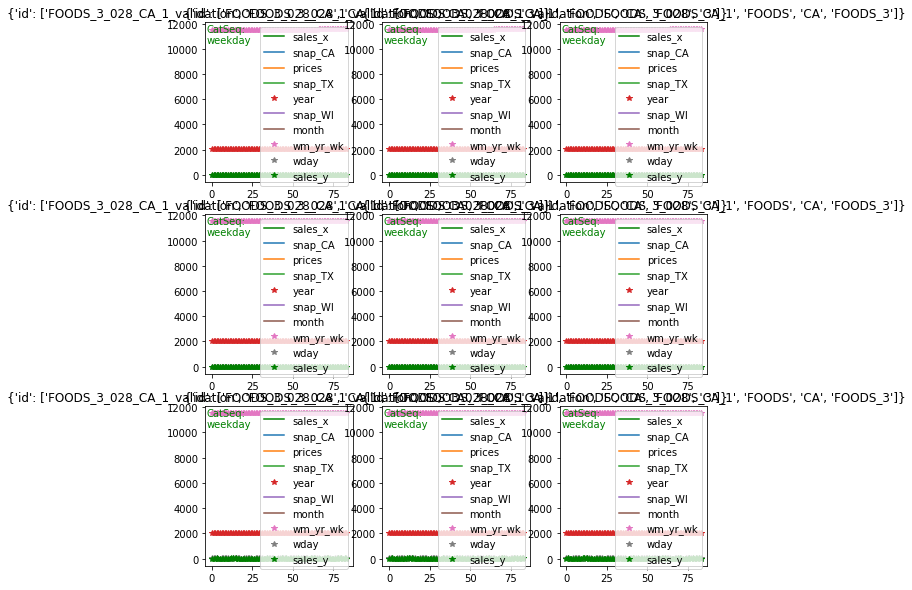

In [63]:
lookback, horizon = 28*2, 28
dl =  MTSDataLoaders.from_m5_path(path, 'sales', horizon = horizon, lookback = lookback,
                                  train_start = 1600, #after_batch = [NormalizeSeqMulti(n_its=5,skip=[0,5])]
                                 )
dl.show_batch()

In [23]:
dl.after_batch

Pipeline: NormalizeSeqMulti

In [24]:
%%time
for o in dl.train:
    pass

CPU times: user 801 ms, sys: 356 ms, total: 1.16 s
Wall time: 2.3 s


In [64]:
for o in dl.train:
    o._dict()
    break

In [65]:
o[-1].mean(),o[-1].std(),o[0].mean(),o[0].std()

(TensorSeq(-0.0369, device='cuda:0'),
 TensorSeq(0.9736, device='cuda:0'),
 TensorSeq(-4.0845e-08, device='cuda:0'),
 TensorSeq(0.9912, device='cuda:0'))

In [66]:
# export
class SeqTab(Module):
    """Basic model for sequential data."""
    def __init__(self, n_cont, out_sz, layers, y_range=None,):
        ps = [0]*len(layers)
        sizes = [n_cont] + layers + [out_sz]
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]
        _layers = [LinBnDrop(sizes[i], sizes[i+1], bn=True and (i!=len(actns)-1), p=p, act=a)
                       for i,(p,a) in enumerate(zip(ps+[0.],actns))]
        if y_range is not None: _layers.append(SigmoidRange(*y_range))
        self.bn_cont = nn.BatchNorm1d(n_cont)
        if y_range is not None: _layers.append(SigmoidRange(*y_range))
        self.layers = nn.Sequential(*_layers)

    def forward(self, x, ts_con, ts_cat, cat, con):
        x_bn = self.bn_cont(x[:,0])
        o = [x, self.layers(x_bn)[:,None,:]]
        return torch.cat(o,-1)

In [67]:
lookback, horizon = 28*2, 28
mdl = SeqTab(lookback,horizon,[200])
shape = list(mdl(torch.randn(16,1,lookback),[],[],[],[]).shape)
test_eq(shape,(16,1,lookback+horizon))
print(shape)

[16, 1, 84]


In [143]:
#export
class M5Learner(Learner): pass

@delegates(M5Learner.__init__)
def SeqTabLearner(dls, layers=None, **kwargs):
    "Get a `Learner` using `data`, with `metrics`, including a `SeqTab` created using the remaining params."
    if layers is None: layers = [200,100]    
    model = SeqTab(dls.train.lookback, dls.train.horizon, layers,)
    return Learner(dls, model, loss_func = F.mse_loss, opt_func= ranger, **kwargs)

In [144]:
learn = SeqTabLearner(dl)

(2.5118865210060903e-08, 0.013182567432522774)

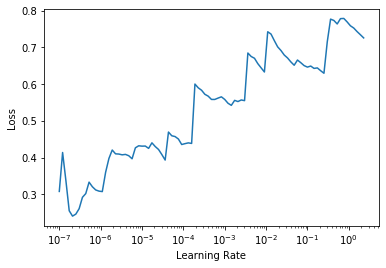

In [145]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.599198,0.543060,00:04
1,0.599189,0.543053,00:04
2,0.599179,0.543045,00:04


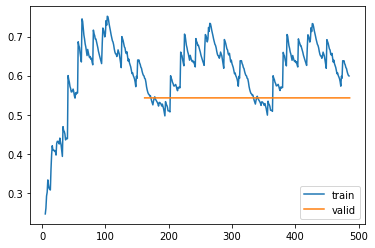

In [146]:
learn.fit(3,1e-7)
learn.recorder.plot_loss()

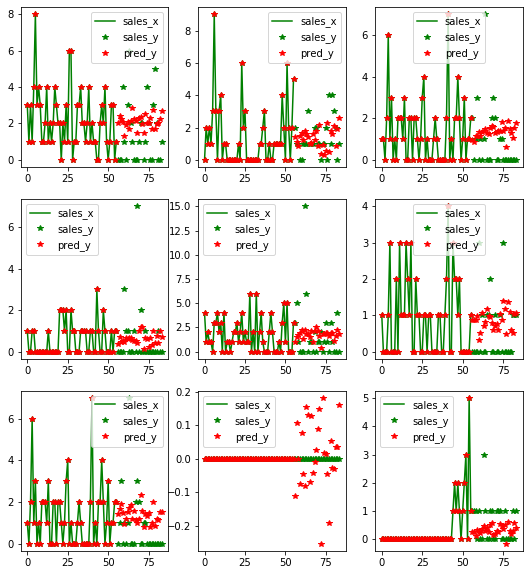

In [147]:
learn.show_results(show_kwargs = dict(extra = False))

In [148]:
pred, target = learn.get_preds(2)
pred.shape, target.shape

(torch.Size([71, 1, 84]), torch.Size([71, 1, 84]))

In [162]:
# export
# inputs,preds,targs,decoded,losses
def make_pred(learn, dl = 2):
    inputs,preds,targs,decoded,losses = learn.get_preds(3, with_decoded = True, with_input=True, with_loss=True)
    predictions = (decoded - targs[:,0,-28:].mean(-1)[:,None,None]).round() #TODO std
    return predictions[:,0,:]
    

1,1,1,1,0,1,1,0,1,1,1,1,0,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1


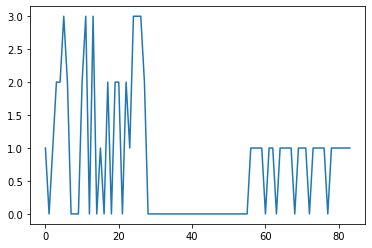

In [163]:
predictions = make_pred(learn, dl = 2)
plt.plot(predictions[0,:])
for pred in predictions:
    o =','.join(L(list(pred[-28:].numpy())).map(int).map(str))
    print(o)
    break
        

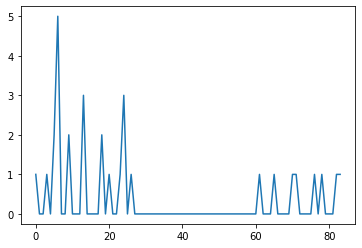

In [164]:
plt.plot(predictions[-1,].T)

In [165]:
# export  
def make_submision_file(learn):
    with open(learn.path / 'submision_file.csv','w') as f:
        f.write('id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28\n')
        for i, (file, pred) in enumerate(zip(learn.dls[2].dataset, make_pred(learn, 2))):
            name = file.name.replace('.json','_validation')
            pred =','.join(L(list(pred[-28:].numpy())).map(int).map(str))
            f.write(name+','+pred+'\n')

        for i, (file, pred) in enumerate(zip(learn.dls[3].dataset, make_pred(learn, 3))):
            name = file.name.replace('.json','_evaluation')
            pred =','.join(L(list(pred[-28:].numpy())).map(int).map(str))
            f.write(name+','+pred+'\n')
            
M5Learner.make_submision_file = make_submision_file

In [166]:
make_submision_file(learn)

In [170]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 00_m5.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.procs.ipynb.
Converted 05_data.m5.ipynb.
Converted 10_model.base.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
Converted tab.model.ipynb.


In [169]:
git_add('10_model.base.ipynb', commit_msg='initial model')

Converted 10_model.base.ipynb.


['/home/tako/dev/fastseq/fastseq/model/base.py',
 '/home/tako/dev/fastseq/nbs/10_model.base.ipynb']